In [90]:
import numpy as np
from matplotlib import pyplot as plt
from scipy.integrate import solve_ivp

In [91]:
ldx_dose_mg = 70
ldx_dose_ug = ldx_dose_mg * 1000

ka = 0.6691
ke = np.log(2) / 10
ke_ldx = 0.9
f = 0.297
Vmax = 60183
Km = 10_000
V = 245_000

params = [ka, ke, ke_ldx, f, Vmax, Km, V]
param_names = ['ka', 'ke', 'ke_ldx', 'f', 'Vmax', 'Km', 'V']

In [92]:
def ldx_model(t, y, ka, ke, ke_ldx, f, Vmax, Km):
    ldx_gi, ldx_p, dex_p = y

    conv = (Vmax * ldx_p) / (Km + ldx_p)

    ldx_gi_dt = -ka * ldx_gi
    ldx_p_dt = ka * ldx_gi - conv - ke_ldx * ldx_p
    dex_p_dt = f* conv - (ke * dex_p)
    
    return [ldx_gi_dt, ldx_p_dt, dex_p_dt]

In [93]:
def get_kinetics(solution, params):
    t = solution.t
    y = solution.y

    C_dex_ng = (y[2] / params[-1]) * 1000
    max_idx = np.argmax(C_dex_ng)

    tmax = t[max_idx]
    cmax = C_dex_ng[max_idx]
    auc = np.trapz(C_dex_ng, t)

    return (tmax, cmax, auc)

In [94]:
def sensitivity_analysis(model_func, outputs_func, params, param_names, perturb=0.05):

    ka, ke, ke_ldx, f, Vmax, Km, V = params
    
    t_span = (0, 72)
    y0 = [ldx_dose_ug, 0, 0]
    t_eval = np.linspace(0, 72, 1000)

    baseline_sol = solve_ivp(
        model_func, t_span, y0,
        t_eval=t_eval,
        args=(ka, ke, ke_ldx, f, Vmax, Km)
    )

    baseline_out = outputs_func(baseline_sol, params)
    sensitivities = {}

    for j, name in enumerate(param_names):
        params_perturb = params.copy()
        params_perturb[j] *= (1 + perturb)

        
        ka_p, ke_p, ke_ldx_p, f_p, Vmax_p, Km_p, V = params_perturb

        sol_p = solve_ivp(
            model_func, t_span, y0, t_eval=t_eval,
            args=(ka_p, ke_p, ke_ldx_p, f_p, Vmax_p, Km_p)
        )

        output_p = outputs_func(sol_p, params_perturb)

        sens = []
        for i in range(len(baseline_out)):
            delta_out = output_p[i] - baseline_out[i]
            delta_param = params_perturb[j] - params[j]
            sens.append((delta_out / baseline_out[i]) / (delta_param / params[j]))

        sensitivities[name] = sens
    return sensitivities

In [95]:
sensitivites = sensitivity_analysis(ldx_model, get_kinetics, params, param_names)
print(sensitivites)

{'ka': [-0.7142857142857134, 0.11418845720388474, -0.05777861160397146], 'ke': [-0.3571428571428548, -0.17407890413619634, -0.9204592193762099], 'ke_ldx': [0.0, -0.16466088924983643, -0.16160279782931372], 'f': [0.0, 0.9999999998608781, 0.9999999999350131], 'Vmax': [0.0, 0.21276804874782806, 0.2121928727149864], 'Km': [0.0, -0.15402947802812816, -0.15278801300023714], 'V': [0.0, -0.9523809523809493, -0.9523809523809493]}


In [96]:
def plot_sensitivity(sensitivity, param_names):
    metrics = ['Tmax', 'Cmax', 'AUC']
    data = np.array([sensitivity[param] for param in param_names]).T
    x = np.arange(len(param_names))

    plt.figure(figsize=(12, 6))
    width = 0.25

    for i in range(len(metrics)):
        plt.bar(x + i * width, data[i], width=width, label=metrics[i])

    plt.xticks(x + width, param_names, rotation=45)
    plt.ylabel("Relative Sensitivity")
    plt.title("Local Sensitivity Analysis")
    plt.axhline(0, color='black', linestyle='--', linewidth=0.8)
    plt.legend()
    plt.tight_layout()
    plt.show()

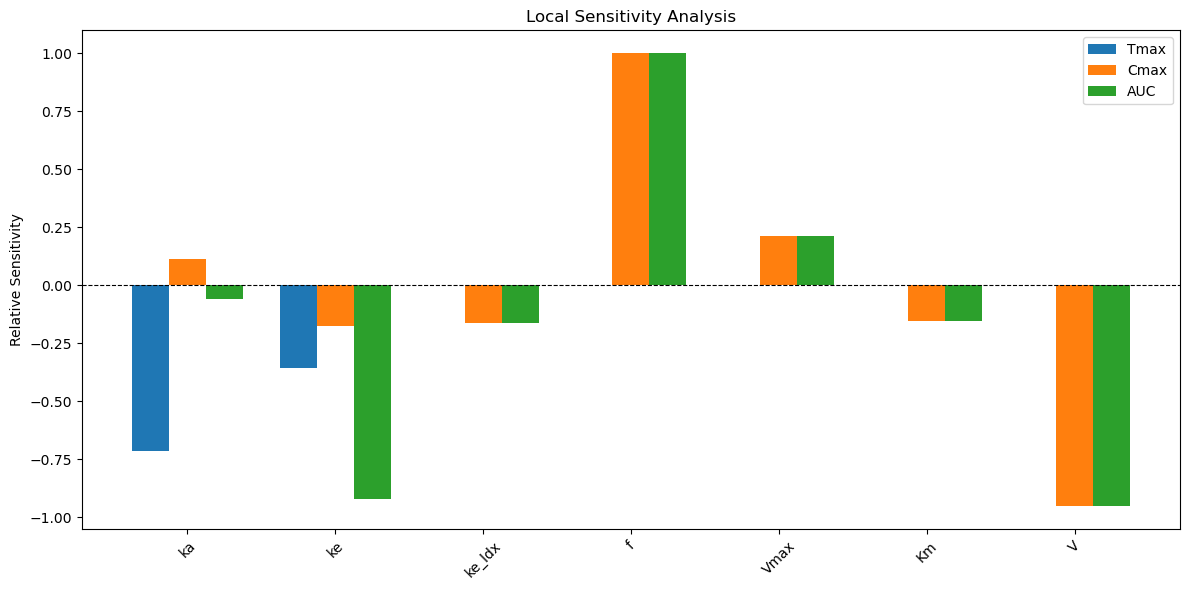

In [97]:
plot_sensitivity(sensitivity=sensitivites, param_names=param_names)